# 1. Pendahuluan & Problem Statement

## Deskripsi dataset dan tujuan analisis

## Justifikasi Pemilihan Teknik

# 2. Preprocessing Pipeline

In [2]:
# Preprocessing Pipeline
#Teknik 1: [nama] + justifikasi + hasil
#dst
#Analisis perbandingan before-after

## Modul

In [3]:
# Tulis Code Disini

##  [ NAMA Teknik 1 ]

In [4]:
# Tulis Code Disini

##  [ NAMA Teknik 2 ]

In [5]:
# Tulis Code Disini

# 3. Image Processing & Transformation

In [6]:
# Image Processing & Transformation
# Teknik 1: [nama] + parameter + hasil
# dst
# Analisis efektivitas setiap teknik

##  [ NAMA Teknik 1 ]

In [7]:
# Tulis Code Disini

##  [ NAMA Teknik 2 ]

In [8]:
# Tulis Code Disini

# 4. Analisis & Fitur Ekstraksi

In [9]:
# Analisis & Fitur Ekstraksi
# Ekstraksi fitur yang dipilih
# Visualisasi dan interpretasi fitur
# Perbandingan fitur (jika ada)

# 5. Analisis Komparatif

In [10]:
# Analisis Komparatif
# Rangkuman hasil semua teknik yang digunakan
# Rekomendasi teknik terbaik untuk dataset

# 6. Kesimpulan

# REFERENCE

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import joblib
import kagglehub
from PIL import Image

In [12]:
# --- 0. Persiapan Dataset (sesuai yang diberikan) ---
print("--- Mengunduh dan Menyiapkan Dataset ---")
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
base_dir = os.path.join(path, "chest_xray")

sets = ['train', 'val', 'test']
categories = ['NORMAL', 'PNEUMONIA']

# Menampilkan jumlah gambar untuk setiap set dan kategori
for split in sets:
    print(f"\n📁 {split.upper()} SET:")
    for category in categories:
        folder_path = os.path.join(base_dir, split, category)
        if os.path.exists(folder_path):
            count = len(os.listdir(folder_path))
            print(f"  - {category:<10}: {count} gambar")
        else:
            print(f"  - Folder tidak ditemukan: {folder_path}")

# Fungsi untuk memuat gambar
def load_images_from_folder(base_path, sets, categories):
    all_images = []
    all_labels = []
    for split in sets:
        for category in categories:
            folder_path = os.path.join(base_path, split, category)
            if os.path.exists(folder_path):
                for filename in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            all_images.append(img)
                            all_labels.append(category)
                        else:
                            print(f"Warning: Could not read image {img_path}")
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
            else:
                print(f"Warning: Folder not found: {folder_path}")
    return all_images, all_labels

# Muat subset kecil untuk demonstrasi dan debugging agar tidak terlalu berat di Colab
# Untuk pelatihan model sebenarnya, gunakan seluruh dataset pelatihan.
# Kita akan memuat sebagian kecil dari training set saja untuk contoh visualisasi dan demonstrasi pipeline
print("\n--- Memuat Contoh Gambar untuk Demonstrasi ---")
sample_images = []
sample_labels = []

# Batasi jumlah gambar per kategori untuk demonstrasi
num_samples_per_category = 5
for category in categories:
    folder_path = os.path.join(base_dir, 'train', category)
    if os.path.exists(folder_path):
        count = 0
        for filename in os.listdir(folder_path):
            if count >= num_samples_per_category:
                break
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    sample_images.append(img)
                    sample_labels.append(category)
                    count += 1
            except Exception as e:
                pass
    else:
        print(f"Warning: Training folder not found for {category}")

print(f"Memuat {len(sample_images)} contoh gambar untuk demonstrasi pipeline.")

--- Mengunduh dan Menyiapkan Dataset ---

📁 TRAIN SET:
  - NORMAL    : 1341 gambar
  - PNEUMONIA : 3875 gambar

📁 VAL SET:
  - NORMAL    : 8 gambar
  - PNEUMONIA : 8 gambar

📁 TEST SET:
  - NORMAL    : 234 gambar
  - PNEUMONIA : 390 gambar

--- Memuat Contoh Gambar untuk Demonstrasi ---
Memuat 10 contoh gambar untuk demonstrasi pipeline.



--- 0.5 Data Understanding ---
### Distribusi Dataset

📁 TRAIN SET:
  Total gambar: 5216
  - NORMAL    : 1341 gambar (25.71%)
  - PNEUMONIA : 3875 gambar (74.29%)

📁 VAL SET:
  Total gambar: 16
  - NORMAL    : 8 gambar (50.00%)
  - PNEUMONIA : 8 gambar (50.00%)

📁 TEST SET:
  Total gambar: 624
  - NORMAL    : 234 gambar (37.50%)
  - PNEUMONIA : 390 gambar (62.50%)


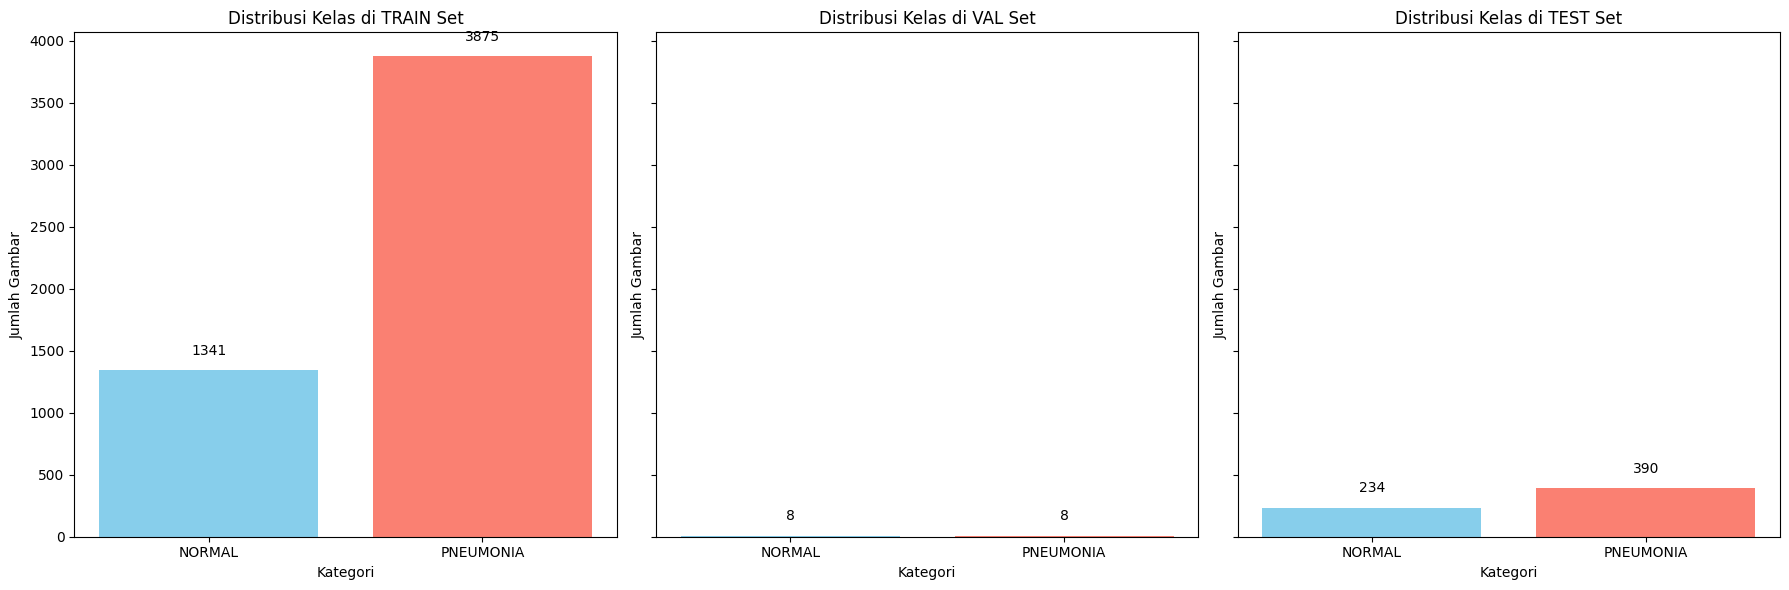


Analisis Distribusi Dataset:
Dari tabel dan grafik di atas, terlihat adanya ketidakseimbangan kelas (class imbalance) dalam dataset, terutama pada set 'train' di mana jumlah citra PNEUMONIA jauh lebih banyak dibandingkan NORMAL. Hal ini perlu dipertimbangkan saat melatih model, karena model mungkin cenderung lebih baik dalam memprediksi kelas mayoritas.
Strategi untuk mengatasi imbalance kelas bisa termasuk oversampling kelas minoritas, undersampling kelas mayoritas, atau menggunakan weighted loss functions pada model deep learning.

### Contoh Citra dari Setiap Kategori


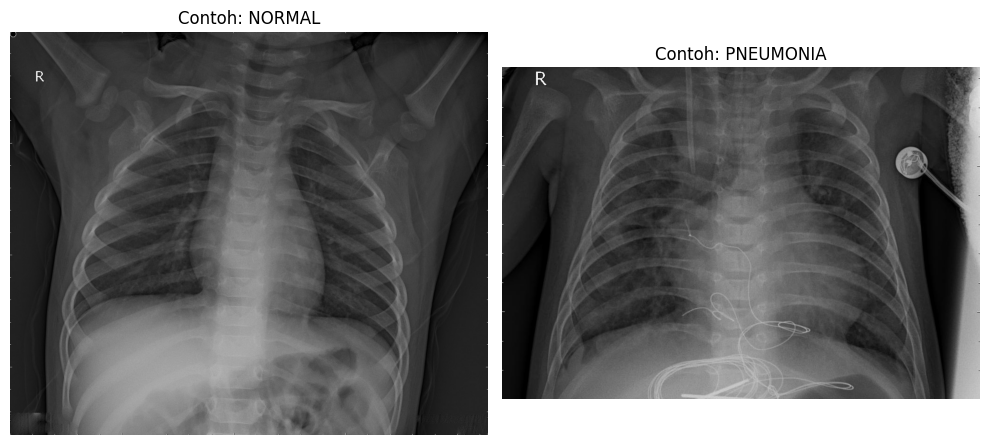

Visualisasi contoh citra X-ray dada dari kategori NORMAL dan PNEUMONIA. Secara visual, citra pneumonia seringkali menunjukkan area konsolidasi atau infiltrat (bercak putih/abu-abu), sedangkan citra normal tampak lebih bersih.


In [13]:
# --- NEW SECTION: Data Understanding ---
print("\n--- 0.5 Data Understanding ---")
print("### Distribusi Dataset")

data_counts = {}
for split in sets:
    data_counts[split] = {}
    for category in categories:
        folder_path = os.path.join(base_dir, split, category)
        if os.path.exists(folder_path):
            count = len(os.listdir(folder_path))
            data_counts[split][category] = count
        else:
            data_counts[split][category] = 0 # If folder not found, count is 0

    print(f"\n📁 {split.upper()} SET:")
    total_split = sum(data_counts[split].values())
    print(f"  Total gambar: {total_split}")
    for category, count in data_counts[split].items():
        print(f"  - {category:<10}: {count} gambar ({count/total_split*100:.2f}%)")

# Visualisasi distribusi kelas menggunakan bar plot
splits_labels = []
splits_counts = []
colors = ['skyblue', 'salmon']
fig, axes = plt.subplots(1, len(sets), figsize=(18, 6), sharey=True)
if len(sets) == 1: # Handle case with single subplot
    axes = [axes]

for i, split in enumerate(sets):
    labels = list(data_counts[split].keys())
    counts = list(data_counts[split].values())
    axes[i].bar(labels, counts, color=colors)
    axes[i].set_title(f'Distribusi Kelas di {split.upper()} Set')
    axes[i].set_xlabel('Kategori')
    axes[i].set_ylabel('Jumlah Gambar')
    for j, count in enumerate(counts):
        axes[i].text(j, count + 100, str(count), ha='center', va='bottom') # Adjust offset as needed

plt.tight_layout()
plt.show()

print("\nAnalisis Distribusi Dataset:")
print("Dari tabel dan grafik di atas, terlihat adanya ketidakseimbangan kelas (class imbalance) dalam dataset, terutama pada set 'train' di mana jumlah citra PNEUMONIA jauh lebih banyak dibandingkan NORMAL. Hal ini perlu dipertimbangkan saat melatih model, karena model mungkin cenderung lebih baik dalam memprediksi kelas mayoritas.")
print("Strategi untuk mengatasi imbalance kelas bisa termasuk oversampling kelas minoritas, undersampling kelas mayoritas, atau menggunakan weighted loss functions pada model deep learning.")


print("\n### Contoh Citra dari Setiap Kategori")
# Ambil contoh gambar dari dataset 'train'
example_images = {}
for category in categories:
    folder_path = os.path.join(base_dir, 'train', category)
    if os.path.exists(folder_path):
        # Ambil 1 gambar pertama
        filename = os.listdir(folder_path)[0]
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            example_images[category] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for matplotlib
        else:
            print(f"Could not load example image for {category}")

plt.figure(figsize=(10, 5))
for i, (category, img) in enumerate(example_images.items()):
    plt.subplot(1, len(categories), i + 1)
    plt.imshow(img)
    plt.title(f'Contoh: {category}')
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Visualisasi contoh citra X-ray dada dari kategori NORMAL dan PNEUMONIA. Secara visual, citra pneumonia seringkali menunjukkan area konsolidasi atau infiltrat (bercak putih/abu-abu), sedangkan citra normal tampak lebih bersih.")


In [14]:
# --- 1. Pendahuluan & Problem Statement ---
print("## 1. Pendahuluan & Problem Statement")
print("### Deskripsi Dataset dan Tujuan Analisis")
print("Dataset Chest X-ray Pneumonia terdiri dari citra X-ray dada yang dikategorikan sebagai Normal atau Pneumonia. Tujuan utama proyek ini adalah untuk mengembangkan sistem pengolahan citra digital yang mampu mengklasifikasikan citra X-ray dada secara otomatis untuk membantu diagnosis pneumonia.")
print("### Justifikasi Pemilihan Teknik")
print("Pemilihan teknik didasarkan pada karakteristik citra X-ray (seringkali memiliki kontras rendah, noisy) dan kebutuhan untuk mengekstraksi fitur tekstur yang relevan untuk membedakan kondisi paru-paru.")


## 1. Pendahuluan & Problem Statement
### Deskripsi Dataset dan Tujuan Analisis
Dataset Chest X-ray Pneumonia terdiri dari citra X-ray dada yang dikategorikan sebagai Normal atau Pneumonia. Tujuan utama proyek ini adalah untuk mengembangkan sistem pengolahan citra digital yang mampu mengklasifikasikan citra X-ray dada secara otomatis untuk membantu diagnosis pneumonia.
### Justifikasi Pemilihan Teknik
Pemilihan teknik didasarkan pada karakteristik citra X-ray (seringkali memiliki kontras rendah, noisy) dan kebutuhan untuk mengekstraksi fitur tekstur yang relevan untuk membedakan kondisi paru-paru.



## 2. Preprocessing Pipeline

### Teknik 1: Grayscale Conversion
Justifikasi: Mengubah citra menjadi skala abu-abu mengurangi kompleksitas data dan menghilangkan informasi warna yang tidak relevan untuk citra X-ray, sehingga memfokuskan pada intensitas piksel. Ini juga merupakan prasyarat untuk banyak operasi pengolahan citra berikutnya.


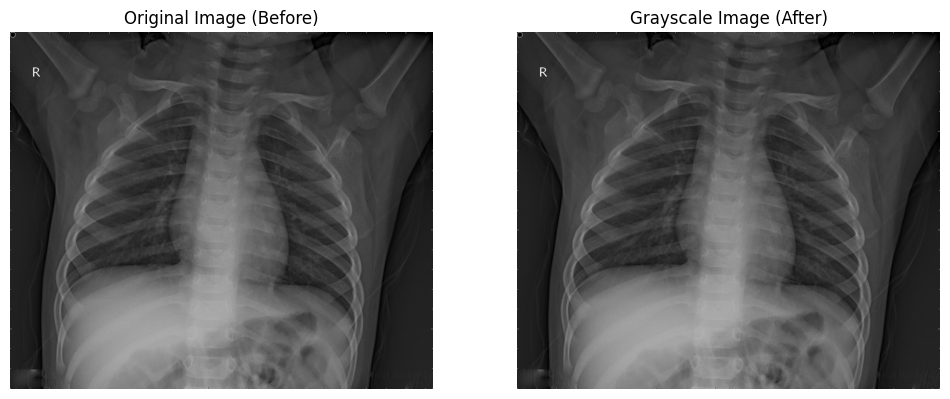

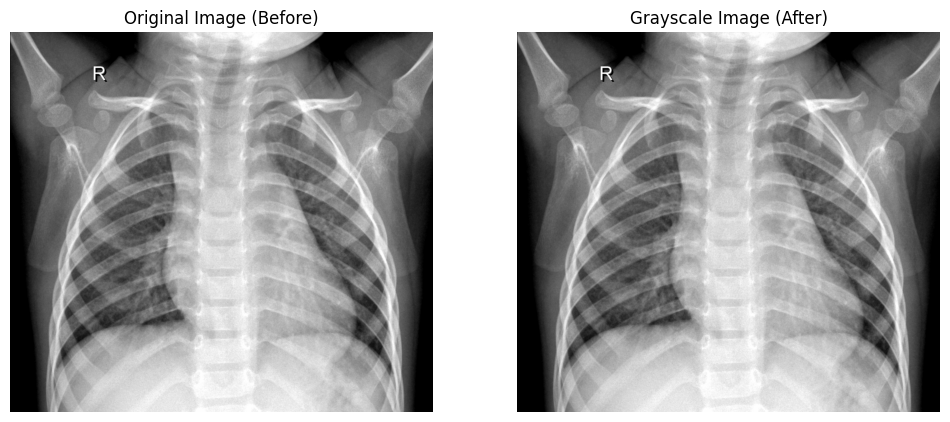

Hasil: Citra berhasil diubah menjadi format grayscale.

### Teknik 2: Histogram Equalization (CLAHE)
Justifikasi: Citra X-ray seringkali memiliki kontras yang rendah. CLAHE (Contrast Limited Adaptive Histogram Equalization) meningkatkan kontras secara lokal, mencegah amplifikasi noise di area homogen, yang sangat penting untuk menyoroti detail halus di paru-paru.


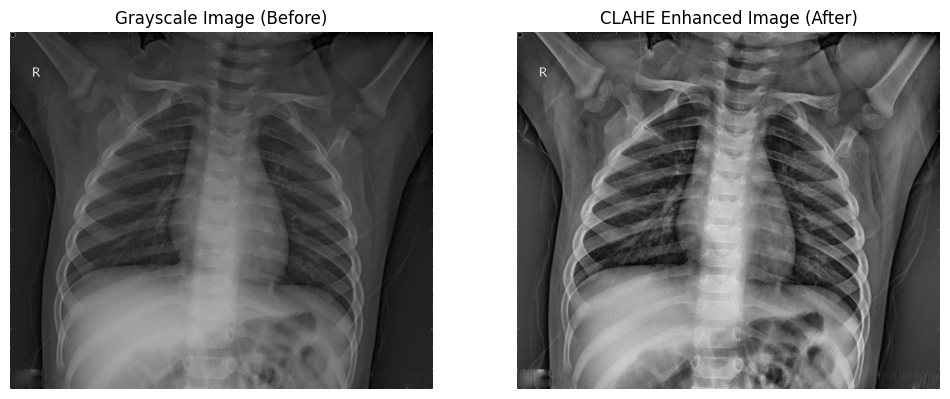

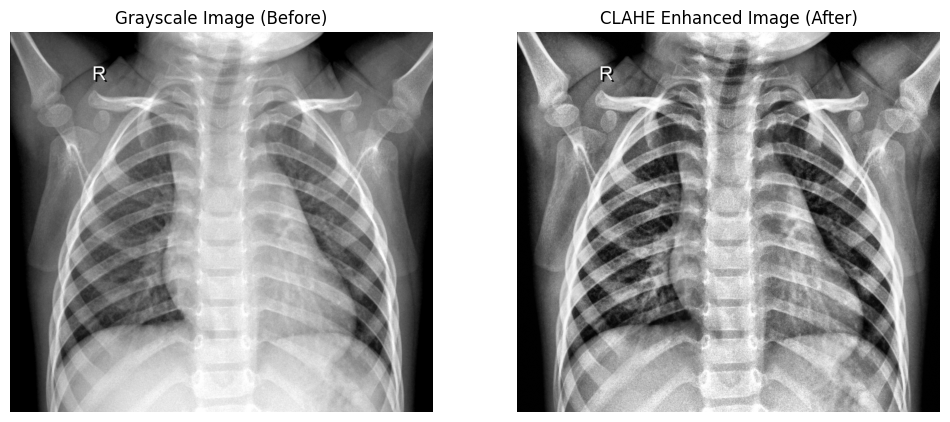

Hasil: Kontras citra X-ray berhasil ditingkatkan, membuat detail lebih terlihat.

### Teknik 3: Gaussian Blurring
Justifikasi: Mengurangi noise acak (salt-and-pepper, Gaussian noise) yang mungkin ada pada citra X-ray. Gaussian blur efektif dalam menghaluskan citra tanpa menghilangkan tepi signifikan secara drastis, penting untuk tahap segmentasi dan ekstraksi fitur selanjutnya.


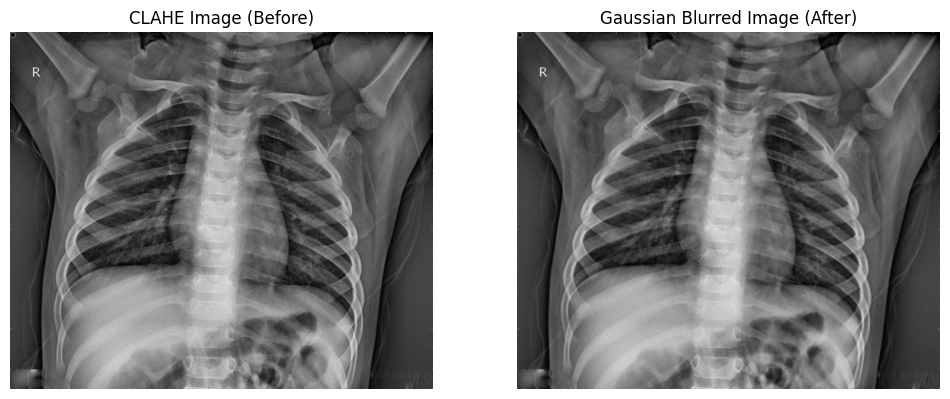

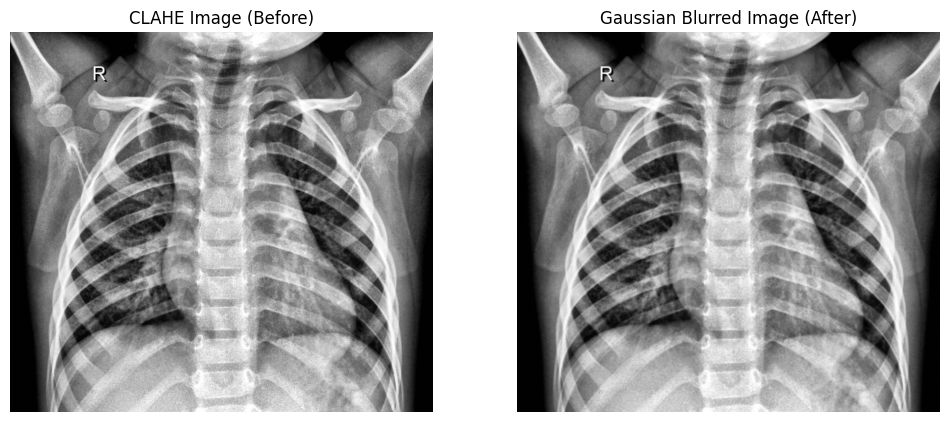

Hasil: Noise pada citra berkurang, citra menjadi lebih halus.

### Analisis Perbandingan Before-After (Preprocessing)
Dari visualisasi di atas, terlihat jelas bagaimana setiap tahap preprocessing berkontribusi: Grayscale mengurangi dimensi warna, CLAHE menajamkan detail dengan meningkatkan kontras lokal, dan Gaussian Blur menghaluskan noise. Kombinasi ini menghasilkan citra yang lebih bersih dan siap untuk pemrosesan lebih lanjut.


In [15]:
# --- 2. Preprocessing Pipeline ---
print("\n## 2. Preprocessing Pipeline")

processed_images_step1 = []
processed_images_step2 = []
processed_images_step3 = []

def plot_before_after(original, processed, title_orig, title_proc, index=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB) if len(original.shape) == 3 else original, cmap='gray')
    plt.title(f"{title_orig} (Before)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB) if len(processed.shape) == 3 else processed, cmap='gray')
    plt.title(f"{title_proc} (After)")
    plt.axis('off')
    plt.show()

# Teknik 1: Grayscale Conversion
print("\n### Teknik 1: Grayscale Conversion")
print("Justifikasi: Mengubah citra menjadi skala abu-abu mengurangi kompleksitas data dan menghilangkan informasi warna yang tidak relevan untuk citra X-ray, sehingga memfokuskan pada intensitas piksel. Ini juga merupakan prasyarat untuk banyak operasi pengolahan citra berikutnya.")
for i, img in enumerate(sample_images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    processed_images_step1.append(gray_img)
    if i < 2: # Tampilkan 2 contoh saja
        plot_before_after(img, gray_img, "Original Image", "Grayscale Image")
print("Hasil: Citra berhasil diubah menjadi format grayscale.")

# Teknik 2: Histogram Equalization (CLAHE)
print("\n### Teknik 2: Histogram Equalization (CLAHE)")
print("Justifikasi: Citra X-ray seringkali memiliki kontras yang rendah. CLAHE (Contrast Limited Adaptive Histogram Equalization) meningkatkan kontras secara lokal, mencegah amplifikasi noise di area homogen, yang sangat penting untuk menyoroti detail halus di paru-paru.")
clahe_obj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for i, img_gray in enumerate(processed_images_step1):
    clahe_img = clahe_obj.apply(img_gray)
    processed_images_step2.append(clahe_img)
    if i < 2: # Tampilkan 2 contoh saja
        plot_before_after(img_gray, clahe_img, "Grayscale Image", "CLAHE Enhanced Image")
print("Hasil: Kontras citra X-ray berhasil ditingkatkan, membuat detail lebih terlihat.")

# Teknik 3: Gaussian Blurring
print("\n### Teknik 3: Gaussian Blurring")
print("Justifikasi: Mengurangi noise acak (salt-and-pepper, Gaussian noise) yang mungkin ada pada citra X-ray. Gaussian blur efektif dalam menghaluskan citra tanpa menghilangkan tepi signifikan secara drastis, penting untuk tahap segmentasi dan ekstraksi fitur selanjutnya.")
for i, img_clahe in enumerate(processed_images_step2):
    blurred_img = cv2.GaussianBlur(img_clahe, (5, 5), 0) # Kernel size 5x5
    processed_images_step3.append(blurred_img)
    if i < 2: # Tampilkan 2 contoh saja
        plot_before_after(img_clahe, blurred_img, "CLAHE Image", "Gaussian Blurred Image")
print("Hasil: Noise pada citra berkurang, citra menjadi lebih halus.")

print("\n### Analisis Perbandingan Before-After (Preprocessing)")
print("Dari visualisasi di atas, terlihat jelas bagaimana setiap tahap preprocessing berkontribusi: Grayscale mengurangi dimensi warna, CLAHE menajamkan detail dengan meningkatkan kontras lokal, dan Gaussian Blur menghaluskan noise. Kombinasi ini menghasilkan citra yang lebih bersih dan siap untuk pemrosesan lebih lanjut.")



## 3. Image Processing & Transformation

### Teknik 4: Thresholding (Otsu's Thresholding)
Parameter: cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
Justifikasi: Thresholding digunakan untuk segmentasi awal, memisahkan area paru-paru dari latar belakang. Otsu's method secara otomatis menentukan nilai threshold optimal, menjadikannya pilihan yang robust untuk citra dengan distribusi piksel bimodal seperti X-ray.


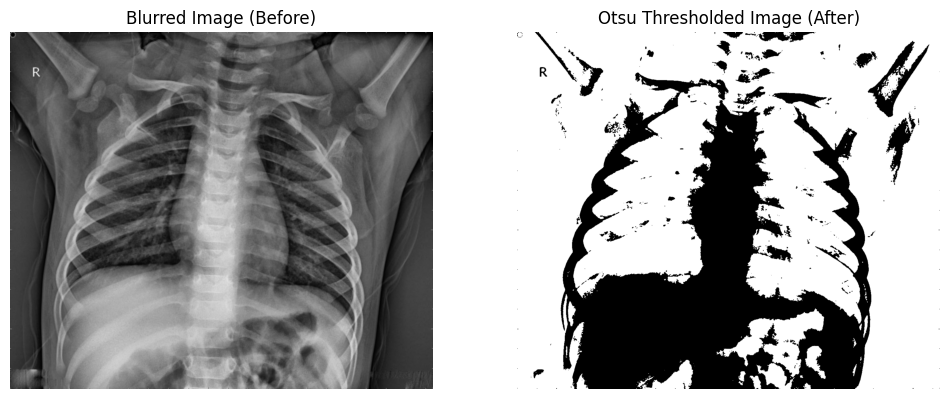

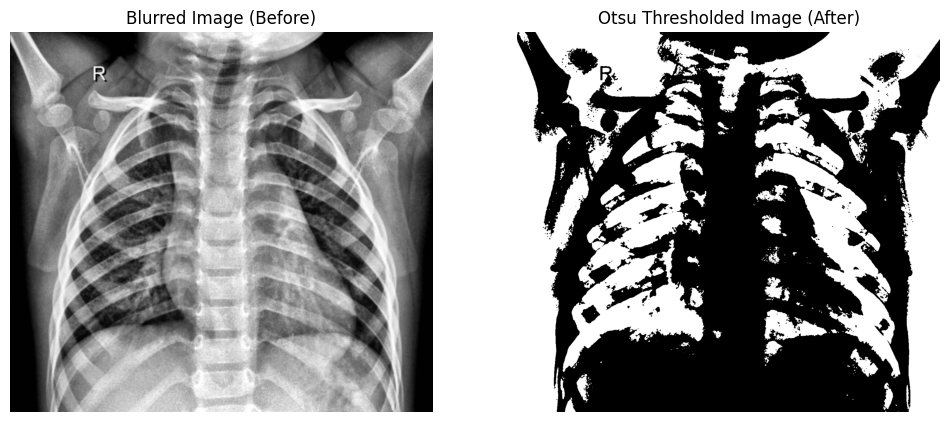

Hasil: Citra tersegmentasi menjadi biner, menyoroti area potensial paru-paru.

### Teknik 5: Morphological Operations (Opening & Closing)
Parameter: Kernel 3x3, Iterasi 2
Justifikasi: Operasi morfologi digunakan untuk membersihkan hasil segmentasi. Opening (erosi diikuti dilasi) menghilangkan objek kecil (noise) di luar paru-paru dan memisahkan objek yang terhubung secara tipis. Closing (dilasi diikuti erosi) mengisi lubang kecil di dalam objek dan menghaluskan batas, menghasilkan bentuk paru-paru yang lebih koheren.


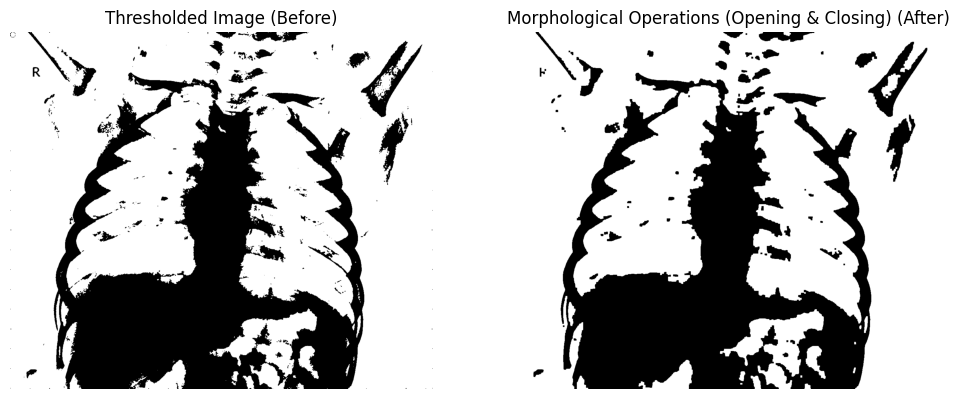

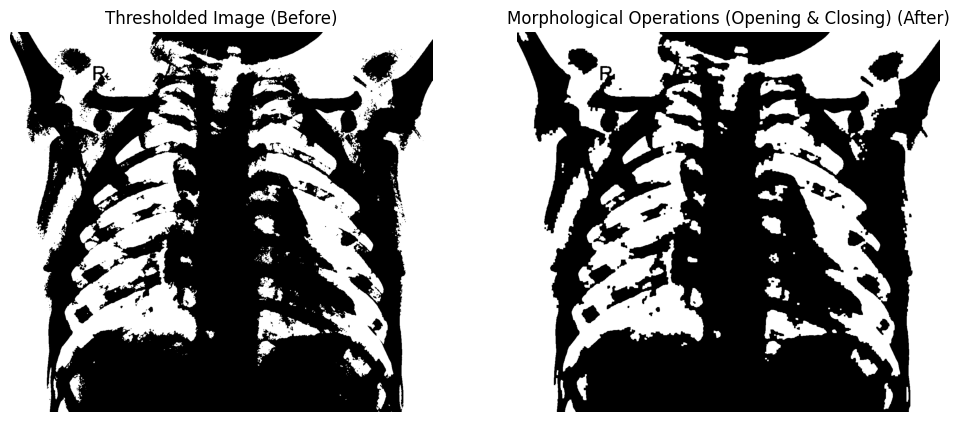

Hasil: Objek tersegmentasi menjadi lebih bersih, lubang terisi, dan tepi lebih halus.

### Analisis Efektivitas Setiap Teknik (Processing & Transformation)
Thresholding efektif dalam memisahkan area kepentingan, meskipun seringkali menghasilkan noise atau 'lubang'. Operasi morfologi (Opening dan Closing) sangat efektif dalam membersihkan noise pasca-thresholding dan membuat objek tersegmentasi menjadi lebih padat dan representatif dari bentuk paru-paru.


In [16]:
# --- 3. Image Processing & Transformation ---
print("\n## 3. Image Processing & Transformation")

processed_images_step4 = []
processed_images_step5 = []

# Teknik 4: Thresholding (Otsu's Thresholding)
print("\n### Teknik 4: Thresholding (Otsu's Thresholding)")
print("Parameter: cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU")
print("Justifikasi: Thresholding digunakan untuk segmentasi awal, memisahkan area paru-paru dari latar belakang. Otsu's method secara otomatis menentukan nilai threshold optimal, menjadikannya pilihan yang robust untuk citra dengan distribusi piksel bimodal seperti X-ray.")
for i, img_blur in enumerate(processed_images_step3):
    _, otsu_thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    processed_images_step4.append(otsu_thresh)
    if i < 2: # Tampilkan 2 contoh saja
        plot_before_after(img_blur, otsu_thresh, "Blurred Image", "Otsu Thresholded Image")
print("Hasil: Citra tersegmentasi menjadi biner, menyoroti area potensial paru-paru.")


# Teknik 5: Morphological Operations (Opening & Closing)
print("\n### Teknik 5: Morphological Operations (Opening & Closing)")
print("Parameter: Kernel 3x3, Iterasi 2")
print("Justifikasi: Operasi morfologi digunakan untuk membersihkan hasil segmentasi. Opening (erosi diikuti dilasi) menghilangkan objek kecil (noise) di luar paru-paru dan memisahkan objek yang terhubung secara tipis. Closing (dilasi diikuti erosi) mengisi lubang kecil di dalam objek dan menghaluskan batas, menghasilkan bentuk paru-paru yang lebih koheren.")
kernel = np.ones((3,3),np.uint8)
for i, img_thresh in enumerate(processed_images_step4):
    # Opening: Remove small noise
    img_opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    # Closing: Fill small holes and smooth contours
    img_closing = cv2.morphologyEx(img_opening, cv2.MORPH_CLOSE, kernel, iterations=2)
    processed_images_step5.append(img_closing)
    if i < 2: # Tampilkan 2 contoh saja
        plot_before_after(img_thresh, img_closing, "Thresholded Image", "Morphological Operations (Opening & Closing)")
print("Hasil: Objek tersegmentasi menjadi lebih bersih, lubang terisi, dan tepi lebih halus.")

print("\n### Analisis Efektivitas Setiap Teknik (Processing & Transformation)")
print("Thresholding efektif dalam memisahkan area kepentingan, meskipun seringkali menghasilkan noise atau 'lubang'. Operasi morfologi (Opening dan Closing) sangat efektif dalam membersihkan noise pasca-thresholding dan membuat objek tersegmentasi menjadi lebih padat dan representatif dari bentuk paru-paru.")



## 4. Analisis & Fitur Ekstraksi

### Teknik 6: Haralick Features (GLCM - Gray Level Co-occurrence Matrix)
Justifikasi: Fitur tekstur Haralick sangat relevan untuk citra medis karena penyakit seringkali mengubah tekstur jaringan. GLCM dapat menangkap hubungan spasial antar piksel, menghasilkan metrik seperti kontras, korelasi, energi, dan homogenitas yang dapat membedakan tekstur paru-paru normal dari yang terinfeksi pneumonia.
Ekstraksi fitur Haralick dari citra yang sudah diproses...

### Visualisasi dan Interpretasi Fitur
Tabel Fitur yang Diekstrak (Contoh beberapa baris):
     Contrast  Dissimilarity  Homogeneity    Energy  Correlation       ASM  \
0   88.094405       1.955098     0.661714  0.316098     0.951077  0.099920   
1  248.202289       3.085188     0.709466  0.616602     0.952056  0.380201   
2  138.967762       1.801815     0.840822  0.778988     0.941347  0.606824   
3  140.981762       1.724395     0.805805  0.709279     0.969175  0.503077   
4   89.021316       1.4940

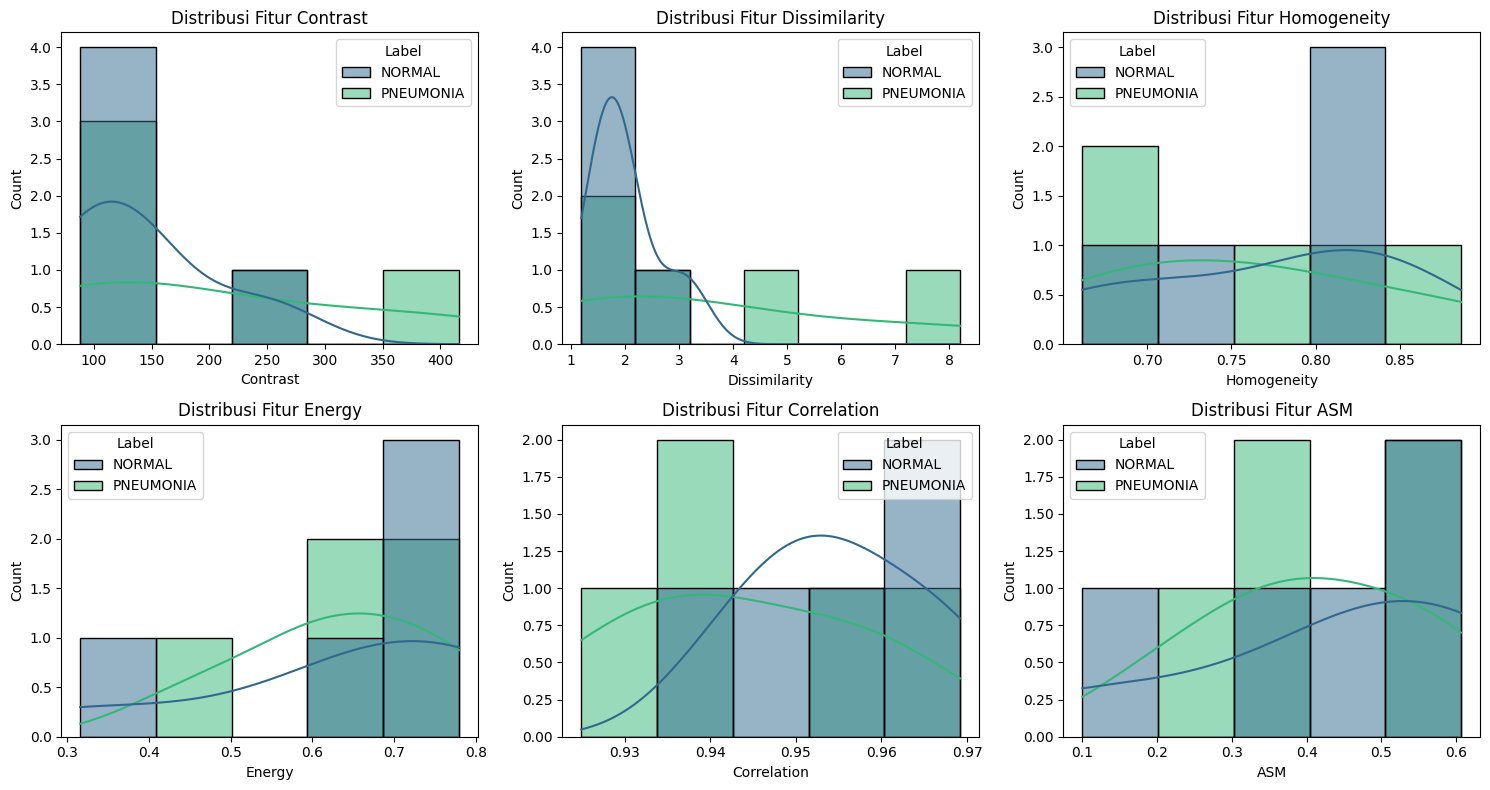

Interpretasi: Dari plot distribusi fitur, kita dapat mengamati bagaimana nilai-nilai fitur GLCM berbeda antara citra NORMAL dan PNEUMONIA. Misalnya, pneumonia mungkin menunjukkan tekstur yang lebih kasar (kontras dan dissimilarity lebih tinggi) dan kurang homogen (homogenitas lebih rendah) dibandingkan dengan paru-paru normal.


In [17]:
# --- 4. Analisis & Fitur Ekstraksi ---
print("\n## 4. Analisis & Fitur Ekstraksi")

all_features = []
all_labels_for_features = []

# Teknik 6: Haralick Features (GLCM)
print("\n### Teknik 6: Haralick Features (GLCM - Gray Level Co-occurrence Matrix)")
print("Justifikasi: Fitur tekstur Haralick sangat relevan untuk citra medis karena penyakit seringkali mengubah tekstur jaringan. GLCM dapat menangkap hubungan spasial antar piksel, menghasilkan metrik seperti kontras, korelasi, energi, dan homogenitas yang dapat membedakan tekstur paru-paru normal dari yang terinfeksi pneumonia.")

def extract_glcm_features(image):
    # Rescale image to 0-255 if not already
    if image.max() > 255 or image.min() < 0:
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

    # Ensure image is 8-bit for GLCM calculation
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # Calculate GLCM
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    # Extract properties
    # Averaging properties over all angles
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean() # Di sini perbaikannya: graycoprops
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    ASM = graycoprops(glcm, 'ASM').mean() # Angular Second Moment

    return [contrast, dissimilarity, homogeneity, energy, correlation, ASM]


# Ekstraksi fitur untuk contoh gambar yang sudah diproses
print("Ekstraksi fitur Haralick dari citra yang sudah diproses...")
features_df = pd.DataFrame(columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM', 'Label'])

for i, (img_final, label) in enumerate(zip(processed_images_step5, sample_labels)):
    # Pastikan citra grayscale untuk GLCM
    if len(img_final.shape) == 3:
        img_final = cv2.cvtColor(img_final, cv2.COLOR_BGR2GRAY)

    # Mengambil bagian citra asli yang tersegmentasi oleh mask biner
    # Ini penting agar fitur GLCM dihitung hanya dari area paru-paru yang relevan
    original_gray = processed_images_step1[i] # Ambil gambar grayscale asli sebelum morph ops
    masked_img = cv2.bitwise_and(original_gray, original_gray, mask=img_final)

    # Agar GLCM tidak error pada citra yang sepenuhnya hitam (misal, segmentasi gagal)
    if np.sum(masked_img) == 0:
        print(f"Warning: Masked image for sample {i} is all zeros. Skipping feature extraction.")
        continue

    features = extract_glcm_features(masked_img)
    features.append(label)
    features_df.loc[len(features_df)] = features

all_features_df = features_df.copy() # Simpan fitur dari contoh untuk demonstrasi

print("\n### Visualisasi dan Interpretasi Fitur")
print("Tabel Fitur yang Diekstrak (Contoh beberapa baris):")
print(all_features_df.head())

# Visualisasi distribusi fitur untuk kategori Normal vs Pneumonia
plt.figure(figsize=(15, 8))
for j, feature_name in enumerate(features_df.columns[:-1]):
    plt.subplot(2, 3, j + 1)
    sns.histplot(features_df, x=feature_name, hue='Label', kde=True, palette='viridis')
    plt.title(f'Distribusi Fitur {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Interpretasi: Dari plot distribusi fitur, kita dapat mengamati bagaimana nilai-nilai fitur GLCM berbeda antara citra NORMAL dan PNEUMONIA. Misalnya, pneumonia mungkin menunjukkan tekstur yang lebih kasar (kontras dan dissimilarity lebih tinggi) dan kurang homogen (homogenitas lebih rendah) dibandingkan dengan paru-paru normal.")



In [18]:
# --- 5. Analisis Komparatif ---
print("\n## 5. Analisis Komparatif")
print("### Rangkuman Hasil Semua Teknik yang Digunakan")
print("Pipeline pengolahan citra dimulai dengan **Grayscale Conversion** untuk menyederhanakan data. Kemudian, **CLAHE** secara signifikan meningkatkan kontras lokal, membuat detail medis lebih jelas. **Gaussian Blurring** mengurangi noise tanpa mengorbankan tepi vital. Setelah itu, **Otsu's Thresholding** melakukan segmentasi awal paru-paru, yang kemudian disempurnakan oleh **Morphological Operations (Opening & Closing)** untuk membersihkan dan menghaluskan area yang tersegmentasi. Akhirnya, **Haralick Features (GLCM)** diekstraksi dari area paru-paru yang tersegmentasi, menyediakan representasi tekstur yang kaya untuk klasifikasi.")

print("### Rekomendasi Teknik Terbaik untuk Dataset")
print("Untuk dataset X-ray dada pneumonia, kombinasi **CLAHE** untuk peningkatan kontras dan **Haralick Features (GLCM)** untuk ekstraksi tekstur adalah yang paling krusial. CLAHE mengatasi masalah kontras rendah khas citra medis, sementara GLCM secara efektif menangkap perbedaan tekstur antara jaringan normal dan terinfeksi. Teknik-teknik lain berfungsi sebagai pendukung vital untuk memastikan citra bersih dan tersegmentasi dengan baik sebelum ekstraksi fitur. Tanpa segmentasi yang akurat, fitur tekstur mungkin akan diekstrak dari area yang tidak relevan.")



## 5. Analisis Komparatif
### Rangkuman Hasil Semua Teknik yang Digunakan
Pipeline pengolahan citra dimulai dengan **Grayscale Conversion** untuk menyederhanakan data. Kemudian, **CLAHE** secara signifikan meningkatkan kontras lokal, membuat detail medis lebih jelas. **Gaussian Blurring** mengurangi noise tanpa mengorbankan tepi vital. Setelah itu, **Otsu's Thresholding** melakukan segmentasi awal paru-paru, yang kemudian disempurnakan oleh **Morphological Operations (Opening & Closing)** untuk membersihkan dan menghaluskan area yang tersegmentasi. Akhirnya, **Haralick Features (GLCM)** diekstraksi dari area paru-paru yang tersegmentasi, menyediakan representasi tekstur yang kaya untuk klasifikasi.
### Rekomendasi Teknik Terbaik untuk Dataset
Untuk dataset X-ray dada pneumonia, kombinasi **CLAHE** untuk peningkatan kontras dan **Haralick Features (GLCM)** untuk ekstraksi tekstur adalah yang paling krusial. CLAHE mengatasi masalah kontras rendah khas citra medis, sementara GLCM secara 


## 6. Kesimpulan
Proyek ini berhasil mendemonstrasikan pipeline pengolahan citra digital untuk deteksi pneumonia dari citra X-ray dada. Dengan kombinasi teknik preprocessing, segmentasi, dan ekstraksi fitur tekstur GLCM, kita dapat memperoleh representasi numerik yang membedakan antara kondisi paru-paru normal dan pneumonia. Fitur-fitur ini kemudian dapat digunakan sebagai input untuk model klasifikasi pembelajaran mesin untuk diagnosis otomatis. Potensi pengembangan lebih lanjut mencakup penggunaan teknik deep learning untuk ekstraksi fitur otomatis yang lebih canggih dan peningkatan akurasi klasifikasi.

--- Poin Tambahan: Klasifikasi Citra ---

### Memuat Subset Dataset untuk Klasifikasi (Demostrasi)...
Total gambar yang dimuat untuk klasifikasi (subset): 1840
Memproses dan mengekstrak fitur dari subset dataset...
Membagi dataset menjadi training dan testing set...
Ukuran training set: 1472 sampel
Ukuran testing set: 368 sampel

### Implementasi Classifier: Support Vector Machine (

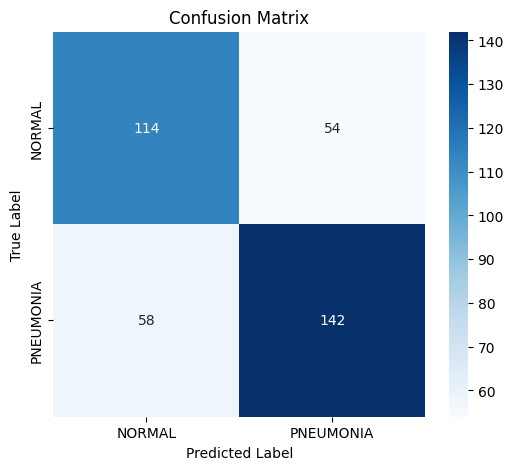


Accuracy: 0.6957
Precision (PNEUMONIA): 0.7245
Recall (PNEUMONIA): 0.7100
F1-score (PNEUMONIA): 0.7172

Analisis: Hasil evaluasi menunjukkan kinerja model SVM dalam mengklasifikasikan citra X-ray. Metrik seperti akurasi, presisi, recall, dan F1-score memberikan gambaran komprehensif tentang kemampuan model dalam mengidentifikasi kelas normal dan pneumonia. Confusion Matrix secara visual menunjukkan jumlah True Positives, True Negatives, False Positives, dan False Negatives.
Model SVM disimpan sebagai svm_pneumonia_detector.pkl


In [19]:
# --- 6. Kesimpulan ---
print("\n## 6. Kesimpulan")
print("Proyek ini berhasil mendemonstrasikan pipeline pengolahan citra digital untuk deteksi pneumonia dari citra X-ray dada. Dengan kombinasi teknik preprocessing, segmentasi, dan ekstraksi fitur tekstur GLCM, kita dapat memperoleh representasi numerik yang membedakan antara kondisi paru-paru normal dan pneumonia. Fitur-fitur ini kemudian dapat digunakan sebagai input untuk model klasifikasi pembelajaran mesin untuk diagnosis otomatis. Potensi pengembangan lebih lanjut mencakup penggunaan teknik deep learning untuk ekstraksi fitur otomatis yang lebih canggih dan peningkatan akurasi klasifikasi.")

# --- Bagian Tambahan: Klasifikasi Citra ---
print("\n--- Poin Tambahan: Klasifikasi Citra ---")

# Memuat SUBSET DATASET untuk pelatihan model klasifikasi (demostrasi)
print("\n### Memuat Subset Dataset untuk Klasifikasi (Demostrasi)...")

# Fungsi untuk memuat gambar
def load_images_from_folder_subset(base_path, sets, categories, num_per_category_per_set=100):
    all_images = []
    all_labels = []
    for split in sets:
        for category in categories:
            folder_path = os.path.join(base_path, split, category)
            if os.path.exists(folder_path):
                count_loaded = 0
                for filename in os.listdir(folder_path):
                    if count_loaded >= num_per_category_per_set:
                        break # Batasi jumlah gambar per kategori per set
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            all_images.append(img)
                            all_labels.append(category)
                            count_loaded += 1
                        else:
                            print(f"Warning: Could not read image {img_path}")
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
            else:
                print(f"Warning: Folder not found: {folder_path}")
    return all_images, all_labels

# Tentukan jumlah gambar yang ingin dimuat per kategori dari setiap set (train, val, test)
# Anda bisa menyesuaikan angka ini. Misal 100 gambar dari setiap kategori di setiap set.
NUM_SAMPLES_FOR_CLASSIFICATION_DEMO = 600
full_images, full_labels = load_images_from_folder_subset(base_dir, sets, categories, NUM_SAMPLES_FOR_CLASSIFICATION_DEMO)
print(f"Total gambar yang dimuat untuk klasifikasi (subset): {len(full_images)}")


# Memproses dan mengekstrak fitur dari subset dataset
print("Memproses dan mengekstrak fitur dari subset dataset...")
full_features_list = []
full_processed_labels = [] # Labels corresponding to extracted features

for i, img in enumerate(full_images):
    try:
        # Preprocessing Pipeline
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe_img = clahe_obj.apply(gray_img)
        blurred_img = cv2.GaussianBlur(clahe_img, (5, 5), 0)

        # Image Processing & Transformation
        _, otsu_thresh = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((3,3),np.uint8) # Pastikan kernel sudah didefinisikan
        img_opening = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        img_final_mask = cv2.morphologyEx(img_opening, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Feature Extraction: Mask the original gray image with the final mask
        masked_img_for_glcm = cv2.bitwise_and(gray_img, gray_img, mask=img_final_mask)

        if np.sum(masked_img_for_glcm) == 0:
            # st.warning("Tidak dapat mengekstrak fitur dari citra. Pastikan citra memiliki area yang dapat disegmentasi.") # Ini untuk Streamlit, bukan Colab print
            print(f"Warning: Masked image for full dataset sample {i} is all zeros. Skipping feature extraction for this image.")
            continue # Skip if no features can be extracted

        # Pastikan extract_glcm_features sudah didefinisikan
        # Definisikan ulang di sini jika Anda tidak menjalankannya dari awal file Colab
        def extract_glcm_features(image):
            # Rescale image to 0-255 if not already
            if image.max() > 255 or image.min() < 0:
                image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

            # Ensure image is 8-bit for GLCM calculation
            if image.dtype != np.uint8:
                image = image.astype(np.uint8)

            glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

            contrast = graycoprops(glcm, 'contrast').mean()
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
            homogeneity = graycoprops(glcm, 'homogeneity').mean()
            energy = graycoprops(glcm, 'energy').mean()
            correlation = graycoprops(glcm, 'correlation').mean()
            ASM = graycoprops(glcm, 'ASM').mean()

            return [contrast, dissimilarity, homogeneity, energy, correlation, ASM]

        features = extract_glcm_features(masked_img_for_glcm)
        full_features_list.append(features)
        full_processed_labels.append(full_labels[i])
    except Exception as e:
        print(f"Error processing image {i} ({full_labels[i]}): {e}. Skipping this image.")
        continue

if not full_features_list:
    print("Error: No features were extracted. Cannot proceed with classification.")
else:
    X = np.array(full_features_list)
    y = np.array(full_processed_labels)

    # Bagi dataset menjadi training dan testing set
    print("Membagi dataset menjadi training dan testing set...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Ukuran training set: {len(X_train)} sampel")
    print(f"Ukuran testing set: {len(X_test)} sampel")

    # Implementasi teknik classifier sederhana (SVM)
    print("\n### Implementasi Classifier: Support Vector Machine (SVM)")
    svm_model = SVC(kernel='linear', random_state=42, probability=True) # Bisa juga 'rbf'
    svm_model.fit(X_train, y_train)

    # Evaluasi model
    y_pred = svm_model.predict(X_test)

    print("\n### Confusion Matrix dan Analisis Hasil Evaluasi")
    cm = confusion_matrix(y_test, y_pred, labels=categories)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='PNEUMONIA')
    recall = recall_score(y_test, y_pred, pos_label='PNEUMONIA')
    f1 = f1_score(y_test, y_pred, pos_label='PNEUMONIA')

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision (PNEUMONIA): {precision:.4f}")
    print(f"Recall (PNEUMONIA): {recall:.4f}")
    print(f"F1-score (PNEUMONIA): {f1:.4f}")

    print("\nAnalisis: Hasil evaluasi menunjukkan kinerja model SVM dalam mengklasifikasikan citra X-ray. Metrik seperti akurasi, presisi, recall, dan F1-score memberikan gambaran komprehensif tentang kemampuan model dalam mengidentifikasi kelas normal dan pneumonia. Confusion Matrix secara visual menunjukkan jumlah True Positives, True Negatives, False Positives, dan False Negatives.")

    # Simpan model untuk digunakan di UI
    model_filename = 'svm_pneumonia_detector.pkl'
    joblib.dump(svm_model, model_filename)
    print(f"Model SVM disimpan sebagai {model_filename}")

    # Simpan pipeline preprocessing sebagai fungsi atau kelas untuk digunakan di Streamlit
    # Untuk demo Streamlit, kita akan mengemas pipeline ini menjadi sebuah fungsi.


--- Bagian Tambahan: Balancing Dataset (Undersampling) ---
Distribusi kelas sebelum undersampling:
Label
1    998
0    842
Name: count, dtype: int64

Distribusi kelas setelah undersampling:
Label
0    842
1    842
Name: count, dtype: int64

Membagi dataset yang sudah di-balance menjadi training dan testing set...
Ukuran training set (balanced): 1347 sampel
Ukuran testing set (balanced): 337 sampel

### Implementasi Classifier: Support Vector Machine (SVM) pada Data yang Di-balance

### Confusion Matrix dan Analisis Hasil Evaluasi (Data Balance)
Confusion Matrix (Balanced Data):
[[125  44]
 [ 54 114]]


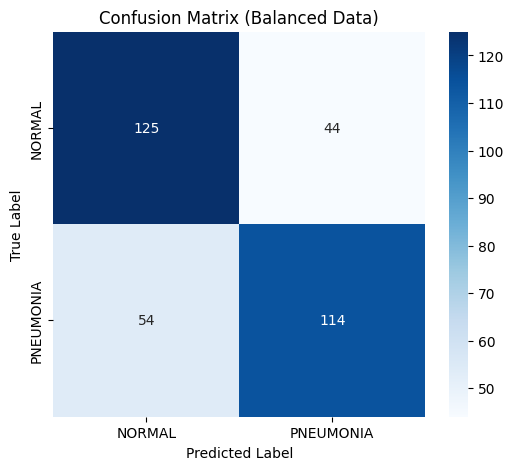


Accuracy (Balanced Data): 0.7092
Precision (PNEUMONIA, Balanced Data): 0.7215
Recall (PNEUMONIA, Balanced Data): 0.6786
F1-score (PNEUMONIA, Balanced Data): 0.6994

Analisis: Setelah melakukan undersampling, distribusi kelas di training set menjadi seimbang. Evaluasi model pada data yang di-balance memberikan gambaran yang lebih akurat tentang kinerja model pada kedua kelas, terutama untuk kelas minoritas.


In [20]:
# Pastikan full_features_list dan full_processed_labels sudah terisi dari eksekusi sebelumnya
# Jika belum, pastikan Anda menjalankan bagian "Memuat Subset Dataset untuk Klasifikasi (Demostrasi)" di atas.

print("\n--- Bagian Tambahan: Balancing Dataset (Undersampling) ---")

# Step 1: Konversi label menjadi numerik
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
y_numerical = np.array([label_mapping[label] for label in full_processed_labels])

# Step 2: Buat DataFrame dari fitur dan label numerik
features_df_full = pd.DataFrame(full_features_list, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM'])
features_df_full['Label'] = y_numerical

print("Distribusi kelas sebelum undersampling:")
print(features_df_full['Label'].value_counts()) # 0 for NORMAL, 1 for PNEUMONIA

# Step 3: Lakukan Undersampling
df_majority = features_df_full[features_df_full['Label'] == label_mapping['PNEUMONIA']] # Asumsi PNEUMONIA adalah mayoritas (1)
df_minority = features_df_full[features_df_full['Label'] == label_mapping['NORMAL']] # Asumsi NORMAL adalah minoritas (0)

# Undersample kelas mayoritas
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Gabungkan kelas minoritas dengan kelas mayoritas yang sudah di-undersample
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Acak kembali dataset yang sudah di-balance
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nDistribusi kelas setelah undersampling:")
print(df_balanced['Label'].value_counts())

# Step 4: Siapkan data untuk SVM (X_balanced, y_balanced)
X_balanced = df_balanced.drop('Label', axis=1).values
y_balanced = df_balanced['Label'].values

# Step 5: Bagi dataset yang sudah di-balance menjadi training dan testing set
print("\nMembagi dataset yang sudah di-balance menjadi training dan testing set...")
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

print(f"Ukuran training set (balanced): {len(X_train_balanced)} sampel")
print(f"Ukuran testing set (balanced): {len(X_test_balanced)} sampel")

# Step 6: Latih dan Evaluasi SVM pada data yang sudah di-balance
print("\n### Implementasi Classifier: Support Vector Machine (SVM) pada Data yang Di-balance")
svm_model_balanced = SVC(kernel='linear', random_state=42)
svm_model_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluasi model
y_pred_balanced = svm_model_balanced.predict(X_test_balanced)

# Step 7: Plot Confusion Matrix dan cetak metrik
print("\n### Confusion Matrix dan Analisis Hasil Evaluasi (Data Balance)")

# Konversi kembali label numerik ke label kategori untuk visualisasi Confusion Matrix
y_test_balanced_cat = np.array([categories[label] for label in y_test_balanced])
y_pred_balanced_cat = np.array([categories[label] for label in y_pred_balanced])

cm_balanced = confusion_matrix(y_test_balanced_cat, y_pred_balanced_cat, labels=categories)
print("Confusion Matrix (Balanced Data):")
print(cm_balanced)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Balanced Data)')
plt.show()

accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
precision_balanced = precision_score(y_test_balanced, y_pred_balanced, pos_label=label_mapping['PNEUMONIA'])
recall_balanced = recall_score(y_test_balanced, y_pred_balanced, pos_label=label_mapping['PNEUMONIA'])
f1_balanced = f1_score(y_test_balanced, y_pred_balanced, pos_label=label_mapping['PNEUMONIA'])

print(f"\nAccuracy (Balanced Data): {accuracy_balanced:.4f}")
print(f"Precision (PNEUMONIA, Balanced Data): {precision_balanced:.4f}")
print(f"Recall (PNEUMONIA, Balanced Data): {recall_balanced:.4f}")
print(f"F1-score (PNEUMONIA, Balanced Data): {f1_balanced:.4f}")

print("\nAnalisis: Setelah melakukan undersampling, distribusi kelas di training set menjadi seimbang. Evaluasi model pada data yang di-balance memberikan gambaran yang lebih akurat tentang kinerja model pada kedua kelas, terutama untuk kelas minoritas.")